![alt text](markdown\vgg16_original.png)

# Take the pre-trained VGG16 model

In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

Using TensorFlow backend.


# Pre-processing the train and validation datasets, feed into the pre-trained model and get the bottleneck features

In [3]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16
datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
generator = datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 1000 images will be one class, then 1000 another
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
# bottleneck_features_train = base_model.predict_generator(generator, 2000)
bottleneck_features_train = base_model.predict_generator(generator, int(np.ceil(1500 / batch_size)))

Error we got:
![alt text](markdown\died.png)
Cause: lack of memory
<br>
Solution: increase memory

In [7]:
# save the output as a Numpy array
# np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)
# np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
np.save('bottleneck_features_train.npy', bottleneck_features_train)

Error we got:
![alt text](markdown\error1.png)
Cause: probably due to the version of python and numpy
<br>
Solution: open in binary mode or use np.save directly without open

In [8]:
generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
# bottleneck_features_validation = model.predict_generator(generator, 800)
bottleneck_features_validation = base_model.predict_generator(generator, int(np.ceil(200 / batch_size)))

Found 200 images belonging to 2 classes.


In [9]:
# np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)
# np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

# Label the bottleneck features which will be the input of the classifier we build

In [4]:
# train_data = np.load(open('bottleneck_features_train.npy'))
# train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_data = np.load('bottleneck_features_train.npy')
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 750 + [1] * 750)

Error we got:
![alt text](markdown\error2.png)
Cause: probably due to the version of python and numpy
<br>
Solution: open in binary mode or use np.load directly without open

In [5]:
# validation_data = np.load(open('bottleneck_features_validation.npy'))
# validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array([0] * 100 + [1] * 100)

![alt text](markdown\vgg16.png)

# Build the classifier and train it using the bottleneck features.

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

Error we got when we try to train the model:
![alt text](markdown\error3.png)
Cause: when we call base_model.predict_generator(generator, 2000), we didn't devide the number of samples by the batch size. So it generates 2000 * 16 = 32000 samples.
<br>
Solution: devide the number of samples by the batch size

In [13]:
top_model = Sequential(name="fully-connected")
top_model.add(Flatten(input_shape=base_model.output_shape[1:], name="flatten"))
top_model.add(Dense(256, activation='relu', name="fc1"))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid', name="predictions"))

# top_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
top_model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr = 0.01), metrics=['accuracy'])

history = top_model.fit(train_data, train_labels,
          epochs=300,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

Train on 1500 samples, validate on 200 samples
Epoch 1/300
1500/1500 [==============================] - 6s - loss: 0.6946 - acc: 0.6600 - val_loss: 0.5725 - val_acc: 0.6350
Epoch 2/300
1500/1500 [==============================] - 5s - loss: 0.4938 - acc: 0.7713 - val_loss: 0.5843 - val_acc: 0.6450
Epoch 3/300
1500/1500 [==============================] - 5s - loss: 0.4417 - acc: 0.7907 - val_loss: 0.3247 - val_acc: 0.8450
Epoch 4/300
1500/1500 [==============================] - 5s - loss: 0.4385 - acc: 0.7927 - val_loss: 0.3430 - val_acc: 0.8500
Epoch 5/300
1500/1500 [==============================] - 5s - loss: 0.3866 - acc: 0.8300 - val_loss: 0.3046 - val_acc: 0.8500
Epoch 6/300
1500/1500 [==============================] - 5s - loss: 0.3741 - acc: 0.8353 - val_loss: 0.3816 - val_acc: 0.8100
Epoch 7/300
1500/1500 [==============================] - 5s - loss: 0.3450 - acc: 0.8487 - val_loss: 0.3167 - val_acc: 0.8850
Epoch 8/300
1500/1500 [==============================] - 5s - loss: 0.3

1500/1500 [==============================] - 5s - loss: 0.1176 - acc: 0.9500 - val_loss: 0.2884 - val_acc: 0.8850
Epoch 130/300
1500/1500 [==============================] - 5s - loss: 0.1415 - acc: 0.9460 - val_loss: 0.3669 - val_acc: 0.8450
Epoch 131/300
1500/1500 [==============================] - 5s - loss: 0.1361 - acc: 0.9500 - val_loss: 0.2789 - val_acc: 0.9000
Epoch 132/300
1500/1500 [==============================] - 5s - loss: 0.1232 - acc: 0.9493 - val_loss: 0.4028 - val_acc: 0.8550
Epoch 133/300
1500/1500 [==============================] - 5s - loss: 0.1615 - acc: 0.9320 - val_loss: 0.2911 - val_acc: 0.8750
Epoch 134/300
1500/1500 [==============================] - 5s - loss: 0.0865 - acc: 0.9627 - val_loss: 0.2747 - val_acc: 0.9000
Epoch 135/300
1500/1500 [==============================] - 5s - loss: 0.1715 - acc: 0.9280 - val_loss: 0.2856 - val_acc: 0.8850
Epoch 136/300
1500/1500 [==============================] - 5s - loss: 0.1160 - acc: 0.9553 - val_loss: 0.2496 - val_ac

1500/1500 [==============================] - 5s - loss: 0.1055 - acc: 0.9567 - val_loss: 0.3093 - val_acc: 0.9100
Epoch 258/300
1500/1500 [==============================] - 5s - loss: 0.1154 - acc: 0.9500 - val_loss: 0.3212 - val_acc: 0.9100
Epoch 259/300
1500/1500 [==============================] - 5s - loss: 0.1257 - acc: 0.9353 - val_loss: 0.3143 - val_acc: 0.8800
Epoch 260/300
1500/1500 [==============================] - 5s - loss: 0.1719 - acc: 0.9220 - val_loss: 0.2467 - val_acc: 0.9050
Epoch 261/300
1500/1500 [==============================] - 5s - loss: 0.1778 - acc: 0.9160 - val_loss: 0.2502 - val_acc: 0.9050
Epoch 262/300
1500/1500 [==============================] - 5s - loss: 0.1228 - acc: 0.9447 - val_loss: 0.2414 - val_acc: 0.9150
Epoch 263/300
1500/1500 [==============================] - 5s - loss: 0.1192 - acc: 0.9467 - val_loss: 0.2646 - val_acc: 0.9000
Epoch 264/300
1500/1500 [==============================] - 5s - loss: 0.1287 - acc: 0.9427 - val_loss: 0.2377 - val_ac

In [84]:
top_model.save_weights('bottleneck_weights.h5')

In [53]:
np.save('history_dropoutdot5_lrdot0001_epoch300.npy', history.history)

# Show the trainning history

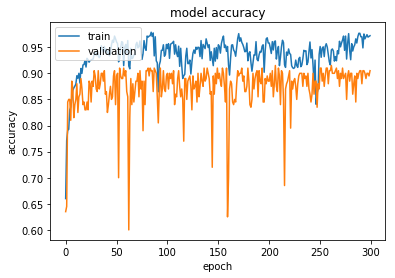

In [14]:
import matplotlib.pyplot as plt
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

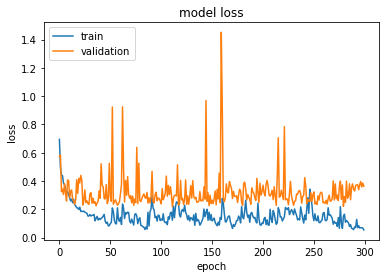

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Connect the pre-trained VGG16 convolutional blocks to our trained classifier and evaluate the model using the test dateset

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

top_model = Sequential(name="fully-connected")
top_model.add(Flatten(input_shape=base_model.output_shape[1:], name="flatten"))
top_model.add(Dense(256, activation='relu', name="fc1"))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid', name="predictions"))

top_model.load_weights('bottleneck_weights.h5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr = 0.01), metrics=['accuracy'])

In [5]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 128 images belonging to 2 classes.


In [6]:
model.evaluate_generator(test_generator, steps=int(np.ceil(128 / batch_size)), max_queue_size=10, workers=1, use_multiprocessing=False)

[0.44558364525437355, 0.8125]